# Импорт библиотек

In [1]:
# import libraries
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Загружаем данные

In [2]:
data_train = pd.read_csv('../data/train.csv')

In [3]:
data_train = data_train.dropna()

In [4]:
# создадим колонку "month" и замапим ее названиями месяцов
data_train['month'] = data_train.day.map(lambda x: int(str(x)[5:-3])).map({
    1:'january', 2:'february', 3:'march', 4:'april',
    5:'may', 6:'june', 7:'july', 8:'august', 
    9:'september', 10:'october', 11:'november', 12:'december'})

# Немного красивых картинок

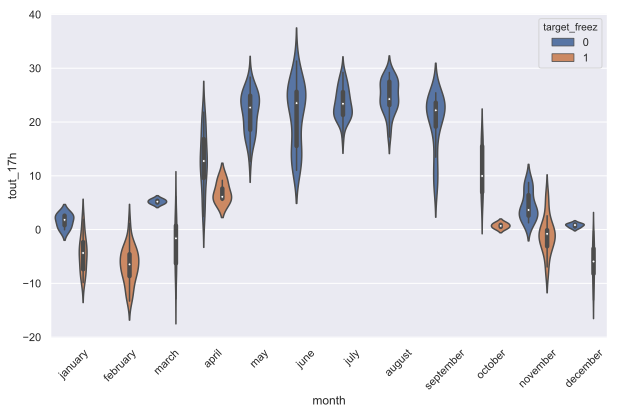

In [5]:
# построим виолины для параметров и разделим их по целевой переменной
sns.set(rc={'figure.figsize':(10, 6)})
plt.xticks(rotation=45)
sns.violinplot(x='month', y='tout_17h', data=data_train, hue='target_freez')

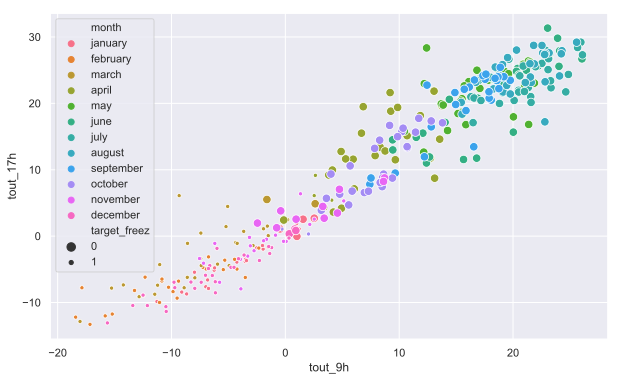

In [6]:
sns.scatterplot(x='tout_9h', y='tout_17h', data=data_train, hue='month', size='target_freez')

# Анализ главных компонент

Применяем способ понижения размерности, так как сейчас много фич и они сильно коррелированы друг с другом

Для лучшей работы PCA применим StandartScaler к данным

In [7]:
# попробуем уменьшить размер данных с помощью алгоритма PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

In [8]:
# применить масштабирование признаков (существенно стало лучше)
scaler = StandardScaler()
X_scaler = scaler.fit_transform(data_train.drop(['day', 'target_freez', 'target_tout', 'month'], axis=1))

In [9]:
pca = PCA(n_components=2, random_state=42)
kpca = KernelPCA(n_components=7, n_jobs=-1, random_state=42, kernel='rbf', degree=3)

In [10]:
X_pca = pca.fit_transform(X=X_scaler)
X_kpca = kpca.fit_transform(X=X_scaler)

In [11]:
df_pca = pd.DataFrame({'day':data_train.day, 
                      'pca_1':X_pca[:, 0], 
                      'pca_2':X_pca[:, 1], 
                      'kpca_1':X_kpca[:, 0], 
                      'kpca_2':X_kpca[:, 1]})

In [12]:
data_train = data_train.merge(df_pca, on='day', how='outer')

# Визуализация  работы алгоритма PCA

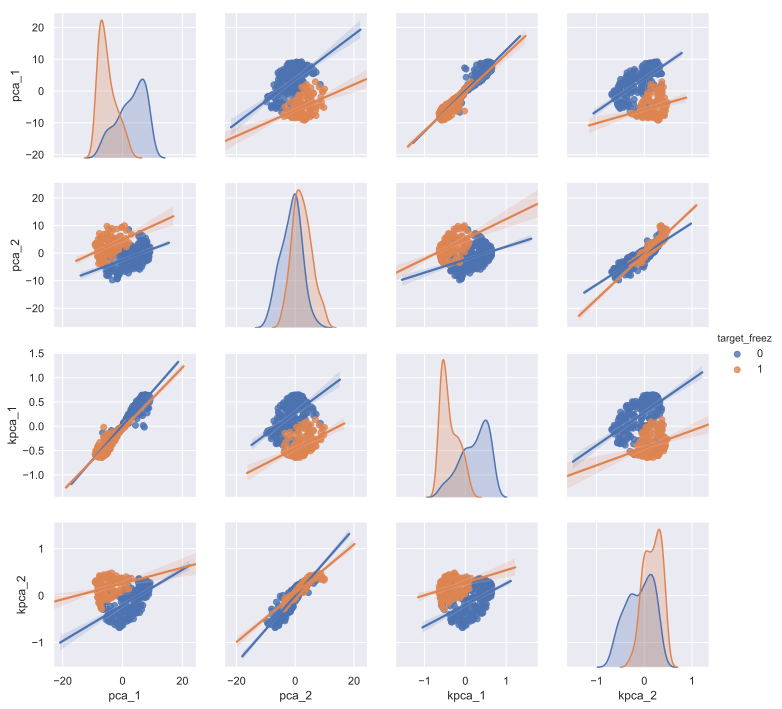

In [13]:
sns.pairplot(data=data_train[['pca_1', 'pca_2', 'kpca_1', 'kpca_2', 'target_freez']],
             hue='target_freez', kind='reg', 
             vars=data_train[['pca_1', 'pca_2', 'kpca_1', 'kpca_2']].columns)

# ScatterPlot для новых компонент

Заметно,что данные легко разделить на два класса, используя новое представление данных

(используем фичи, полученные с помощью ядерного PCA)

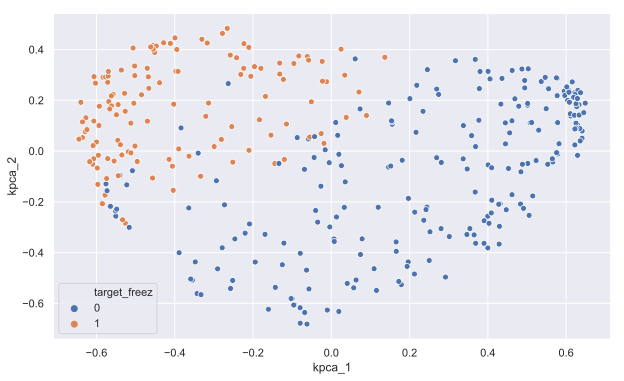

In [16]:
sns.scatterplot(x='kpca_1', y='kpca_2', data=data_train, hue='target_freez')

# Сохраняем датасет

Датасет начальный плюс новые фичи
- ***train_pca.csv*** - данные для построения модели с добавленными новыми признаками
- ***X.csv, y.csv*** - признаки и целевая переменная (в виде классов) соответственно
- ***y_reg.csv*** - целевая переменная в виде температуры (для предсказаний)

In [17]:
data_train.to_csv('../data/train_pca.csv', index=False)
data_train.drop(['month', 'day', 'target_tout', 'target_freez'], axis=1).to_csv('../data/X.csv', index=False)
data_train.target_freez.to_csv('../data/y.csv', index=False, header=True)
data_train.target_tout.to_csv('../data/y_reg.csv', index=False, header=True)